# super vector machine

是一种**二分类模型**，其**目的**是使得不同类样本间隔最大化，以实现正确分类

**基本思想**：在特征空间中寻找包含max margin的分割超平面

**三个法宝**：margin，dual，kernel method


可分为二类：
- 线性SVM
 - hard-margin SVM
 - soft-margin SVM
- 非线性SVM
 - kernel SVM
   

## 1. 线性SVM

### 1. 1hard-margin SVM $y_i\in\{-1, +1\}$

**适用条件**：样本线性可分

准备数据集

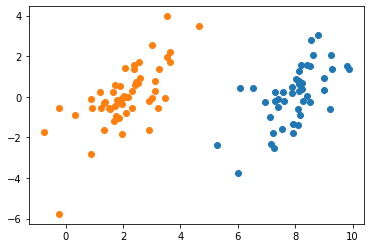

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def loadDataSet(fileName):
    """    加载数据集

    :param fileName: 文件路径
    :return:
        dataMat - 数据
        labelMat -  label
    """
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t') # 源文件使用制表符分割数据
        dataMat.append([float(i) for i in lineArr[0:2]])
        labelMat.append(float(lineArr[2]))
    return dataMat, labelMat

def showDataSet(dataMat, labeMat):
    """     数据可视化

    :param dataMat: 数据数组, array.size=(bz, 2)
    :param labeMat: 标签数组, array.size=(bz)
    :return:
    """
    data_pos, data_neg = [], [];
    for (x, y) in zip(dataMat, labeMat):
        if (y==-1): data_neg.append(x);
        else: data_pos.append(x);
    data_pos = np.array(data_pos)
    data_neg = np.array(data_neg)
    plt.scatter(np.transpose(data_pos)[0], np.transpose(data_pos)[1])
    plt.scatter(np.transpose(data_neg)[0], np.transpose(data_neg)[1])
    plt.show()

dataMat, dataLabel = loadDataSet("ML_master/SVM/testSet.txt")
showDataSet(dataMat, dataLabel)


**Model**：$f(w) = sign(w^Tx+b)$

**Objective Function:** 
$$
\begin{aligned}
\max margin(w, b) &= \max_{w, b}\min_{x_i} distance(w,b,x_i) \\
&= \max_{w, b} \min_{x_i} \frac{1}{||w||}\cdot |w^Tx_i + b| \\
&= \max_{w, b} \min_{x_i} \frac{1}{||w||}\cdot y_i(w^Tx_i + b)， （最大化几何间隔） \\
\end{aligned}
$$
$$
s.t. y_i(w^tx_i+b) > 0, \forall i=1,...,N
$$

对于目标函数中的 $\min_{x_i} y_i(w^Tx_i + b)$来说，它表示的是**一个$x_i$与$x_j$的最小几何距离**（因为两点的几何距离是确定的），我们可以将其rescaling到1，故原问题的等价优化问题：
$$
\begin{aligned}
&\left\{
\begin{aligned}
&\max_{w, b}\frac{1}{||w||},\\
&s.t. \min_{x_i,\ y_i\\ i=1, ..., N} y_i(w^tx_i+b) = 1
\end{aligned}
\right.\\
\iff
&\left\{
\begin{aligned}
&\min_{w, b}\frac{1}{2} w^Tw,\\
&s.t. y_i(w^tx_i+b) >= 1,\ \forall x_i
\end{aligned}
\right.
\end{aligned}
$$



**对偶算法**

这是一个凸二次规划问题。因此，我们应用拉格朗日对偶性，通过求解对偶问题得到原始问题的最优解。
这样做的优点：
- 对偶问题往往更容易求解
- 自然引入核函数，进而推广至非线性分类问题

原问题的拉格朗日函数为：
$$
\ell (w, b, \lambda) = \frac{1}{2}||w||^2-\sum^N_{i=1}(\lambda_iy_i(w\cdot x_i+b)+1)
$$

则拉格朗日对偶函数为：
$$
g(\lambda, \mu) = \inf_{x\in D}\ell (w, b, \lambda)
$$
因为g是关于$\lambda$与$\mu$的极小化仿射函数，故他是一个凹函数（无论L是否凸）。
根据g的定义，我们知道对于$\forall \lambda\geq0$与$\forall \mu$都有$g\leq p*$，这里$p*$是原问题的最优解.
这说明了g是原问题最优解$p*$的下界，所以我们只需要$\max g(\lambda, \mu)$这个下界，就能使得g尽可能逼近$p*$.

因此，原问题的拉格朗日对偶问题为：

$$
\left\{
\begin{aligned}
&\min_{w,b}\max g(\lambda, \mu) = \min_{w,b}\max_{\lambda} \ell (w, b, \lambda),\\
&s.t. \lambda_i \ge 0
\end{aligned}
\right.
$$

该优化问题满足KKT条件，故根据强对偶关系，原始问题可转化为极大极小问题：
$$\max_{\lambda}\min_{w,b}\ell (w, b, \lambda)$$



(1) 求$\min_{w,b}\ell (w, b, \lambda)$

将$\ell$分别对w,b求偏导数，并令其等于0,得到Eq(1)
$$
\begin{aligned}
\nabla_w \ell = w-\sum_{i=1}^N \lambda_iy_ix_i = 0\\
\nabla_b \ell = \sum_{i=1}^N \lambda_iy_i = 0
\end{aligned}
$$
将第一个式子带入$\ell$函数，并利用2式可得：
$$
\min_{w,b}\ell = -\frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N\lambda_i\lambda_jy_iy_j(x_i\cdot x_j) + \sum_{i=1}^N\lambda_i
$$

(2) 求$min_{w,b} \ell (w, b, \lambda)$ 对$\lambda$的极大，即极大化对偶问题的下界
$$
\begin{aligned}
\max_{\lambda} &-\frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N\lambda_i\lambda_jy_iy_j(x_i\cdot x_j) + \sum_{i=1}^N\lambda_i\\
s.t. &\sum_{i=1}^N\lambda_iy_i, \ \ where\ \lambda_i\geq0, i=1,2,...,N
\end{aligned}
$$

对于线性可分训练数据集，假设对偶最优化问题对$\lambda$ 的解为$\lambda^*$，则将$\lambda^*$带入Eq (1)可求得

$$
\begin{aligned}
&w^* = \sum_{i=1}^N \lambda^*_iy_ix_i\\
&b^* = y_i - \sum_{i=1}^N \lambda^*_iy_i(x_i\cdot x_j)
\end{aligned}
$$

## 2 序列最小最优化 （Sequential Minimal Optimaization, SMO）算法

尽管凸二次规划问题能够求出全局最优的解析解，但是当**样本容量很大**的时候，算法会变得非常低效，故此，SMO算法被提出来 了。

### 2.1 简介

SMO算法是一种启发式算法，其基本思路是：

如果所有变量的解都满足此最优化问题的KKT条件,那么这个最优化问题的解就得到了。因为KKT条件是该最优化问题的充分必要条件，**否则**，选择两个变量，固定其他变量，针对这两个变量构建一个二次规划问题。这个二次规问题关于这两个变量的解应该**更接近**原始二次规划问题的解，因为这会使得原始二次规划问题的目标函数值变得更小。

重要的是，这时子问题可以通过解析方法求解，这样就可以大大提高整个算法的计算速度.

子问题有两个变量，一个是**违反KKT条件最严重**的那一个，另一个**由约束条件自动确定**。如此，SMO算法将原问题不断分解为子问题并对子问题求解，进而达到求解原问题的目的

注意，子问题的两个变量中，只有一个是自由变量。假设$\lambda_1, \lambda_2$为两个变量，$\lambda_3, \lambda_4, ..., \lambda_N$固定，那么由等式约束可知
$$
\lambda_1 = -y_i\sum_{i=2}^N \lambda_i y_i
$$

整个SMO算法包括两个部分：求解两个变量二次规划的解析方法和选择变量的启发式方法




### 2.2 两个变量的二次规划求解方法

不失一般性，假设选择的两个变量是$\lambda_1,\lambda_2$，其他变量$\lambda_i(i=3,4,...,N)是固定的。于是SMO的最优化问题的**子问题**可写成：

$$
\begin{aligned}
\min_{\lambda_1, \lambda_2} W(\lambda_1, \lambda_2)&=\frac{1}{2}\mathcal{K}_{11}\lambda_1^2 + \frac{1}{2}\mathcal{K}_{22}\lambda_2^2 + y_1y_2 \mathcal{K}_{12}\lambda_1\lambda_2\\
&-(\lambda_1+ \lambda_2)+y_1\lambda_1\sum_{i=3}^Ny_i\lambda_i\mathcal{K}_{i1}+y_2\lambda_2\sum_{i=3}^Ny_i\lambda_i\mathcal{K}_{i2}
\end{aligned}
$$

$$
\begin{aligned}
s.t.\ \ &y_1\lambda_1+y_2\lambda_2 = -\sum_{i=3}^Ny_i\lambda_i = \xi \\
&0 \le \lambda_i\le C, \ \ i=1, 2 
\end{aligned}
$$

其中，$\mathcal{K}_{ij}=\mathcal{K}(x_i, x_j), i,j=1,2,..,N, \xi$是常数

先分析变量$\lambda_1, \lambda_2$的可行域，约束可以用二维空间中的图形表示(图中a1，a2为本文中的$\lambda_1, \lambda_2$)
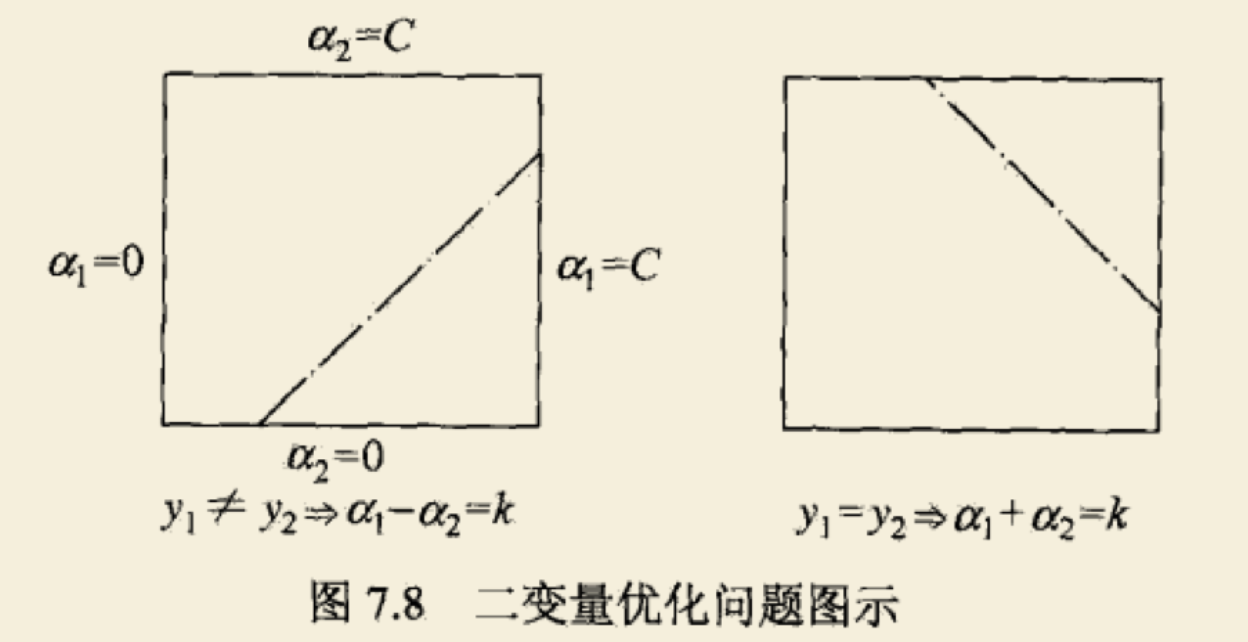
不等式约束使得（$\lambda_1, \lambda_2$）在盒子$[0,C]\times [0, C]$内，等式约束使得（$\lambda_1, \lambda_2$）在平行于盒子对角线的直线上。

因此要求目标函数在一条平行于对角线的线段上的最优值。这使得两个变量的最优化问题成为实质上的**单变量优化问题**，不妨考虑为变量$\lambda_2$的最优化问题。

假设问题的初始可行解为$\lambda^{old}_1, \lambda^{old}_2$, 最优解为$\lambda^{new}_1, \lambda^{new}_2$，并且假设在沿着约束方向未经剪辑时$\lambda_2$的最优解为$\lambda^{new,unc}_2$。

由于$\lambda_2^{new}$需要满足不等式约束，故最优值$\lambda_2^{new}$的取值范围必须满足条件
$$
0\le L\le \lambda_2^{new} \le H \le C
$$
其中，$L$ 与 $H$ 是 $\lambda_2^{new}$ 所在的对角线端点的**界**。如果$y_1\neq y_2$（如图7.8所示），则
$$
L = \max(0, \lambda_2^{old} - \lambda_1^{old}), H = \min(C, C+\lambda_2^{old}-\lambda_1^{old})
$$
如果 $y1= y_2$ （如图7.8右图所示），则
$$
L = \max(0, \lambda_2^{old} + \lambda_1^{old} - C), H = \min(C, \lambda_2^{old}-\lambda_1^{old})
$$

下面，首先求沿着约束方向未经剪辑（即 未考虑不等式约束7.103）时 $\lambda_2$ 的最优解 $\lambda_2^{new,unc}$；
然后再求剪辑后 $\lambda_2$ 的最优解 $\lambda_2^{new}$。
记
$$
g(x) = \sum_{i=1}^N \lambda_i y_i \mathcal{K}(x_i, x) + b \tag{7.104}
$$
令
$$
E_i = g(x_i) - y_i = \left( \sum_{j=1}^N \alpha_j y_j \mathcal{K}(x_j, x_i) + b \right) - y_i, \ \ i=1, 2\tag{7.105}
$$

**定理7.6** 最优化问题(7.101)沿着约束方向未经剪辑时的解是

$$
\lambda_2^{new, unc} = \lambda_2^{old} + \frac{y_2 (E_1-E_2)}{\eta}\tag{7.106}
$$
其中$\eta = \mathcal{K}_{12} + \mathcal{K}_{22}-2\mathcal{K}_{12} = ||\Phi(x_1) +\Phi(x_2)||^2$，$\Phi(x)$是输入空间到特征空间的映射，$E_i$ 由(7.105)给出。

经剪辑后，$\lambda_2$的解为：

$$
\lambda_2^{new} = \left\{
\begin{aligned}
&H, &\lambda_2^{new, unc} > H \\
&\lambda_2^{new, unc}, &L\le \lambda_2^{new, unc} \le H \\
&L, &\lambda_2^{new, unc} < L
\end{aligned}
\right.
$$

由$\lambda_2^{new}求得$$\lambda_1^{new}$ 为：

$$
\lambda_1^{new} = \lambda_1^{old} + y_1y_2(\lambda_2^{old}-\lambda_2^{new}), \tag{7.109}
$$

### 2.3 变量的选择方法

SMO算法在每个子问题中选择**两个变量**来优化，其中**至少一个**变量是**违反KKT条件**的。

#### 2.3.1 第一个变量的选择（外层循环）

SMO在外层循环中选取**违反KKT条件最严重**的样本点，并将其对应的变量作为第一个变量。

具体来说，检验训练样本点$(x_i, y_i)$ 是否满足KKT条件，即

$$
\lambda_i = 0 \iff y_i g(x_i) \ge 1  \tag{7.111}
$$
$$
0<\lambda_i<C \iff y_ig(x_i) = 1 \tag{7.112}
$$
$$
\lambda_i = C \iff y_ig(x_i)\le 1 \tag{7.113}
$$
其中，$g(x_i) = \sum_{j=1}^N \lambda_j y_j \mathcal{K}(x_i, y_i) + b$.

该检验时在 $\epsilon$ 范围内进行的。在检验过程中，外层循环

- 首先**遍历所有满足条件** $0<\lambda_i<C$ 的样本点，即在间隔边界上的支持向量点，检验它们是否满足KKT条件。
- if (这些样本点都满足KKT) ：**遍历整个训练集**

#### 2.3.2 第2个变量的选择（内层循环）

假设在外层循环中已经找到第1个变量$\lambda_1$ , 现在要在内层循环中找第2个变量$\lambda_2$ . 第2个变量的**选择标准**是：能够使$\lambda_2$ 有**足够大的变化**。

由式子$(7.106), (7.108)$ 知，$\lambda_2^{new}$ 的更新依赖于 $|E_1-E_2|$ 的，

为了加快计算速度，**一种简单的做法**是：

- 选择 $\lambda_2$ 使得 对应的 $|E_1 - E_2|$ 最大。因为$\lambda_1$ 已定，$E_1$ 也就确定了。

  - if （$E_1 \ge 0$ ）：选择**最小的** $E_i$ 作为 $E_2$
  - else：选择**最大的** $E_i$ 作为 $E_2$
- 为了节省计算时间，所有的$E_i$ 值都保存在一个列表中

在**特殊情况**下，如果内层循环通过以上方式选择的 $\lambda_2$ **不能使目标函数由足够的下降** ，那么采用以下启发式规则继续选择$\lambda_2$ ：

- for ( 所有在间隔边界上的支持向量点所对应的变量当作$\lambda2$ )
  - 找出能使得目标函数有足够的下降的点，返回
- if （没找到）：
  - for （整个训练数据集）
    - 找出能使得目标函数有足够的下降的点，返回
  - if (没找到)：则**放弃**当前的第 1 个变量$\lambda_1$ ，**回到外层循环**，找下一个$\lambda_1$

#### 2.3.3 计算阈值 b 和差值 $E_i$

在每次完成两个变量的优化后，都要重新计算阈值 $b$ 。 当 $0<\lambda_1^{new}< C$ 时，由KKT条件 $(7.112)$ 可知：

$$
\sum_{i=1}^N \lambda_i y_i K_{i+1} + b = y_1
$$

于是，

$$
b_1^{new} = y_1 - \sum_{i=3}^N \lambda_i y_i \mathcal{K}_{i1} - \lambda_1^{old}y_1\mathcal{K}_{11} - \lambda_2^{new}y_2\mathcal{K}_{21} \tag{7.114}
$$

由 $E_1$的定义式$(7.105)$ 有

$$
E_1 = \sum_{i=3}^N \lambda_i y_i) \mathcal{K} + \lambda_1^{old}y_1\mathcal{K}_{11} + \lambda_2^{old}y_2\mathcal{K}_{21} + b^{old} - y_i
$$

式子$(7.114)$ 的前两项可以写成：

$$
y_1 - \sum_{i=3}^N \lambda_i y_i \mathcal{K}_{i1} = -E_1 + \lambda_1^{old}y_1\mathcal{K}_{11} + \lambda^{old}_2y_2\mathcal{K}_{21}+b^{old}
$$

代入式$(7.114)$, 可得：

$$
b_1^{new} = -E_1 - y_1\mathcal{K}_{11}(\lambda^{new}_1 - \lambda^{old}_1) - y_2\mathcal{K}_{21}(\lambda^{new}_2 - \lambda^{old}_2) + b^{old}. \tag{7.115}
$$

同样， 如果$0<\lambda_2^{new}<C$，那么，

$$
b_2^{new} = -E_2 - y_1\mathcal{K}_{12}(\lambda^{new}_1 - \lambda^{old}_1) - y_2\mathcal{K}_{22}(\lambda^{new}_2 - \lambda^{old}_2) + b^{old}. \tag{7.116}
$$


- 如果$\lambda_1^{new}$, $\lambda_2^{new}$ 同时满足条件 $0<\lambda_i^{new}<C, i=1, 2,$ 那么$b_1^{new} = b_2^{new}$。

- 如果$\lambda_1^{new}, \lambda_2^{new}$ 是 $0 $ 或者 $C$ ，那么$b_1^{new}$ 和 $b_2^{new}$ 以及它们之间的数都是符合 KKT 条件的阈值，则选择**它们的中点**作为 $b^{new}$

在每次完成两个变量的优化之后，还必须更新对应的$E_i$ 值，并将它们保存在列表中。$E_i$ 的更新需要用到$b^{new}$ 值，以及所有支持向量对应的$\lambda_j$:

$$
E_i^{new} = \sum_S y_j\lambda_j\mathcal{K}(x_i, x_j) + b^{new} - y_i, \tag{7.117}
$$

其中，$S$ 是所有支持向量 $x_j$ 的集合。